<a href="https://colab.research.google.com/github/belalabouzaid/siads699_team13_collab/blob/main/Notebooks/03a-PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Objective

The aim of this notebook is to analyze feature importance by using principal component analysis and the number of principal components that would sufficnently preserve the majority of the information in the data, using variance explained as a measure.

# Feature importance by Variance Explained

In [1]:
# Import libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# To work with numpy arrays
import numpy as np
# ML model building, training and testing
import sklearn
# Liner regression model building
from sklearn.linear_model import LinearRegression
# Polynomial regression
from sklearn.preprocessing import PolynomialFeatures
# sklearn included transformer
from sklearn.preprocessing import QuantileTransformer
# to split data into test and train
from sklearn.model_selection import train_test_split
# Scaling transform for PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# To run PCA feature reduction
from sklearn.decomposition import PCA
# XGBoost model
from xgboost import XGBRegressor,XGBClassifier
# Random forest regressor
from sklearn.ensemble import RandomForestRegressor
# for regression error calculation
from sklearn.metrics import mean_absolute_error
# for regression r2 score calculation
from sklearn.metrics import r2_score
# for regression mse score calculation
from sklearn.metrics import mean_squared_error
# For hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
# To transform the target variable into a normal distribution
from sklearn.compose import TransformedTargetRegressor

## Data Loading

In [2]:
mariposa_21 = pd.read_csv('https://github.com/belalabouzaid/siads699_team13_collab/raw/main/Data/mariposa_2021.csv')

In [3]:
threerivers_22 = pd.read_csv('https://github.com/belalabouzaid/siads699_team13_collab/raw/main/Data/threerivers_2022.csv')

In [4]:
# Taking a random sample from the dataset to reduce size (for runtime and plotting)
mariposa_21 = mariposa_21.sample(n = 500, random_state = 42)
threerivers_22 = threerivers_22.sample(n = 500, random_state = 42)

## PCA Analysis for feature importance for Mariposa 21

In [5]:
X = mariposa_21.drop(columns = 'smi')
y = mariposa_21['smi']

In [6]:
X = X[['aspect','slope','NDMI','SR_B5','SAVI','EVI','NDVI','ST_B10'
                                  ,'MNDWI','SR_B7','SR_B6','MSAVI', 'MSI']]

In [7]:
# Recommended to run PCA after scaling features so that variance is calculated and compared equally between features
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [8]:
# Creating a PCA object named pca.
pca = PCA()
X_new = pca.fit_transform(X_scaled)

In [9]:
# The PCA class contains explained_variance_ratio_ which returns the variance explained by each of the principal components.
print(pca.explained_variance_ratio_) # the percentage of the variance

[5.88522595e-01 1.54777718e-01 8.52207837e-02 7.84820544e-02
 5.84985826e-02 2.83002307e-02 2.93746582e-03 1.37787196e-03
 1.03616690e-03 4.61678906e-04 2.09878743e-04 1.31509002e-04
 4.34641572e-05]


In [10]:
# calculating the variance explained (indication of variable importance) from PCA and displaying as a sorted dataframe
pct_variance_explained_dict = {}
col_names = X.columns
for i in range(len(col_names)):
  pct_variance_explained_dict [col_names[i]] = pca.explained_variance_ratio_[i]
var_explained_df = pd.DataFrame.from_dict(pct_variance_explained_dict,orient='index', columns = ['pct_variance_explained'])
var_explained_df['pct_variance_explained'] = var_explained_df['pct_variance_explained']*100
var_explained_df = var_explained_df.sort_values('pct_variance_explained', ascending = False).reset_index()
var_explained_df

,index,pct_variance_explained
0,aspect,58.852259
1,slope,15.477772
2,NDMI,8.522078
3,SR_B5,7.848205
4,SAVI,5.849858
5,EVI,2.830023
6,NDVI,0.293747
7,ST_B10,0.137787
8,MNDWI,0.103617
9,SR_B7,0.046168


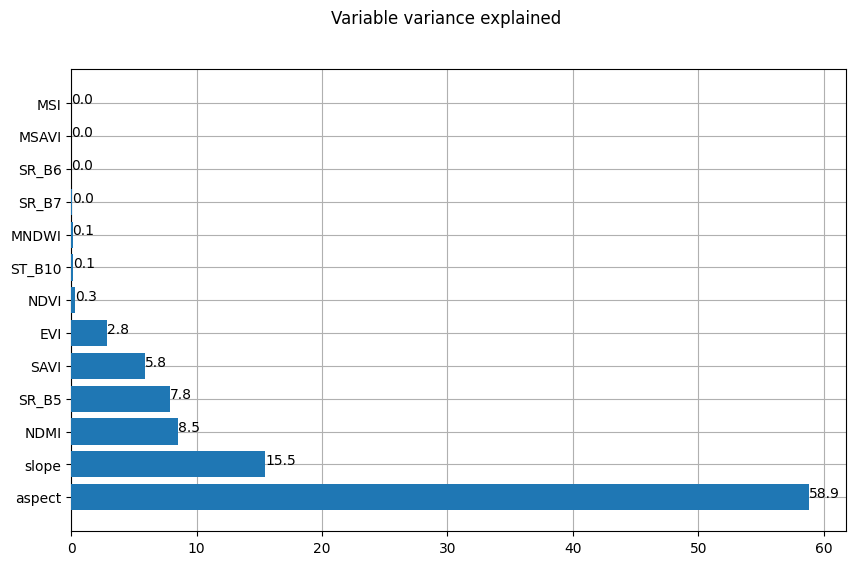

In [11]:
variables = list(var_explained_df['index'])
variance_exp = list(var_explained_df['pct_variance_explained'])
fig, axs = plt.subplots(figsize=(10, 6))
axs.barh(variables, variance_exp, zorder=3)
fig.suptitle('Variable variance explained')
for index, value in enumerate(variance_exp):
    plt.text(value, index,
             str(round(value, 1)))
axs.grid();

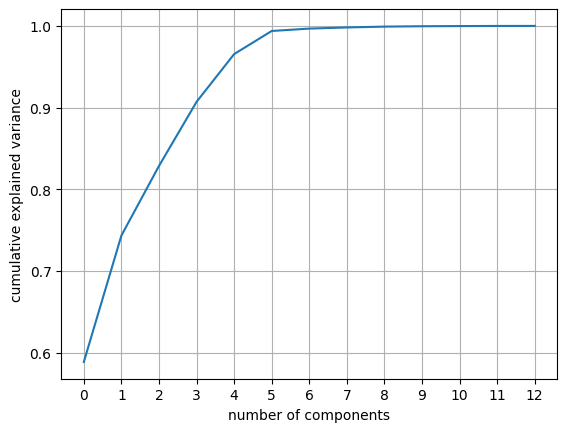

In [12]:
# To better understand the importance of the derived principal components, we can plot the variance per feature and observe the leaerning curve
PCA_fit = PCA().fit(X_scaled)
plt.plot(np.cumsum(PCA_fit.explained_variance_ratio_))
plt.xlabel('number of components')
plt.xticks(np.arange(0, 13, 1.0))
plt.ylabel('cumulative explained variance')
plt.grid();

From the plot above, we can see number of principal components to achieve maximum learning value from the dimentionality reduction.
The dataframe **var_explained_df** shown previously lists the variables in descending order in terms of variance explained (importance)

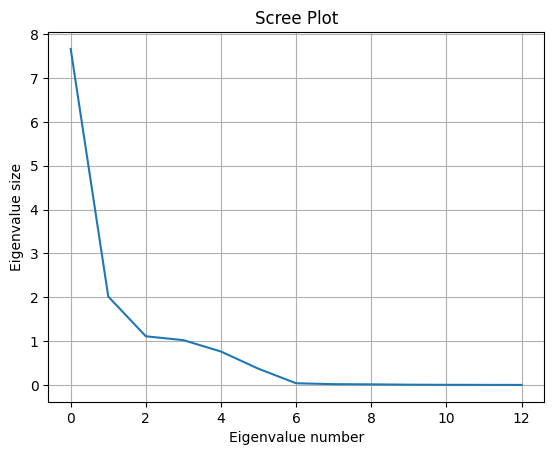

In [13]:
#plt.style.use("ggplot")

eigen_vals = pca.explained_variance_

plt.plot(eigen_vals#, marker='o', color='blue'
         )
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot")
plt.grid()

# plt.savefig('scree plot.png')

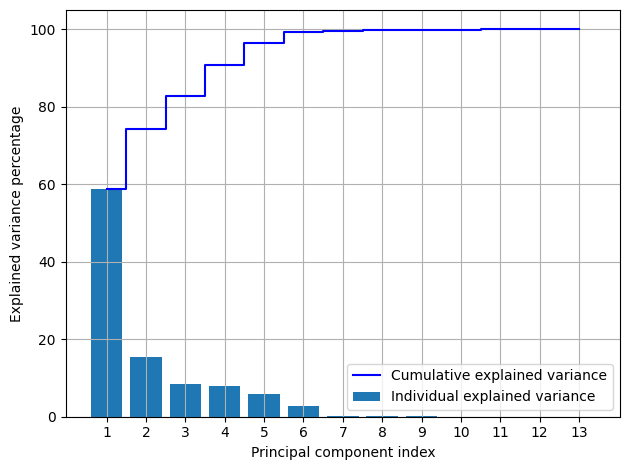

In [14]:
# https://medium.com/data-science-365/2-plots-that-help-me-to-choose-the-right-number-of-principal-components-351a87e15a9f

exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

a = 14 # Number of input features + 1

plt.bar(range(1, a), exp_var, align='center',
        label='Individual explained variance')

plt.step(range(1, a), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='blue')

plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(ticks=list(range(1, a)))
plt.legend(loc='best')
plt.tight_layout()
plt.grid()

The above scree plot and variance explained bar chart both show that 6 principal components are sufficient to preserve the information in the variables selected using variance explained as a measure.

The below visualizations explore which variables contribute to the most important principal components

## PCA for feature importance Three Rivers 22

In [16]:
X = threerivers_22.drop(columns = 'smi')
y = threerivers_22['smi']

In [17]:
X = X[['aspect','slope','NDMI','SR_B5','SAVI','EVI','NDVI','ST_B10'
                                  ,'MNDWI','SR_B7','SR_B6','MSAVI', 'MSI']]

In [18]:
# Recommended to run PCA after scaling features so that variance is calculated and compared equally between features
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [19]:
# Creating a PCA object named pca.
pca = PCA()
X_new = pca.fit_transform(X_scaled)

In [20]:
# The PCA class contains explained_variance_ratio_ which returns the variance explained by each of the principal components.
print(pca.explained_variance_ratio_) # the percentage of the variance

[6.32349044e-01 1.69915527e-01 8.08660779e-02 6.17878952e-02
 3.58497521e-02 1.40952876e-02 2.69245586e-03 1.23507547e-03
 5.75017062e-04 4.49937090e-04 1.25111693e-04 4.12892787e-05
 1.75295181e-05]


In [21]:
# calculating the variance explained (indication of variable importance) from PCA and displaying as a sorted dataframe
pct_variance_explained_dict = {}
col_names = X.columns
for i in range(len(col_names)):
  pct_variance_explained_dict [col_names[i]] = pca.explained_variance_ratio_[i]
var_explained_df = pd.DataFrame.from_dict(pct_variance_explained_dict,orient='index', columns = ['pct_variance_explained'])
var_explained_df['pct_variance_explained'] = var_explained_df['pct_variance_explained']*100
var_explained_df = var_explained_df.sort_values('pct_variance_explained').reset_index()
var_explained_df

,index,pct_variance_explained
0,MSI,0.001753
1,MSAVI,0.004129
2,SR_B6,0.012511
3,SR_B7,0.044994
4,MNDWI,0.057502
5,ST_B10,0.123508
6,NDVI,0.269246
7,EVI,1.409529
8,SAVI,3.584975
9,SR_B5,6.178790


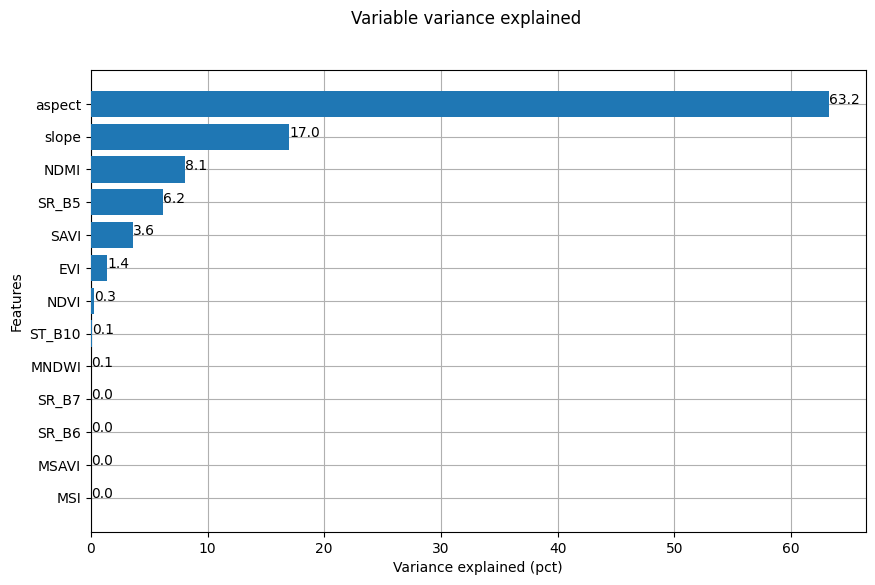

In [28]:
variables = list(var_explained_df['index'])
variance_exp = list(var_explained_df['pct_variance_explained'])
fig, axs = plt.subplots(figsize=(10, 6))
axs.barh(variables, variance_exp, zorder = 3)
fig.suptitle('Variable variance explained')
for index, value in enumerate(variance_exp):
    plt.text(value, index,
             str(round(value, 1)))
plt.ylabel('Features', fontsize=10)
plt.xlabel('Variance explained (pct)', fontsize=10)
axs.grid();